# Magnetic Resonance Imaging Comparisons of Demented and Nondemented Adults
## Trying out different algorithms on the old dataset

In [523]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.svm import SVC
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, we're going to take "oasis_longitudinal" dataset and prepare it like we did before (replacing null values, removing unnecessary columns like Hand and Id, removing converted from group column, changing categirical data to numerical...)

In [524]:
data_long = pd.read_csv('/content/drive/My Drive/Colab Notebooks/oasis_longitudinal.csv')
data_long.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [525]:
data_long.drop(('MRI ID'), axis=1, inplace=True)
data_long.drop(('Hand'), axis=1, inplace=True)
data_long.loc[data_long.SES.isna(),'SES'] = data_long.loc[:,'SES'].median()
data_long.loc[data_long.MMSE.isna(),'MMSE'] = data_long.loc[:,'MMSE'].median()

In [526]:
data_long = data_long[data_long['Visit'] == 1]

In [527]:
data_long = data_long[data_long['Group'] != 'Converted']
unique_values_count = data_long['Group'].nunique()

In [528]:
data_long = data_long.drop(['Visit'],axis=1).drop(['MR Delay'],axis=1).drop(['Subject ID'], axis=1).drop(['CDR'], axis=1)

In M/F column we're going to replace *F* with 0 and *M* with 1, and in the Group column we're going to replace *Nondemented* with 0 and *Demented* with 1.

In [529]:
label_encoder = preprocessing.LabelEncoder()

data_long['M/F']= label_encoder.fit_transform(data_long['M/F'])
data_long['Group']= label_encoder.fit_transform(data_long['Group'])
data_long['Group'] = 1 - data_long['Group']

We are going to divide our data set into training set (80%) and test set (20%).



In [530]:
X = data_long.drop(['Group'],axis=1)
Y = data_long['Group']

In [531]:
data_long.head()

,Group,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,1,87,14,2.0,27.0,1987,0.696,0.883
2,1,1,75,12,2.0,23.0,1678,0.736,1.046
5,0,0,88,18,3.0,28.0,1215,0.710,1.444
7,0,1,80,12,4.0,28.0,1689,0.712,1.039
10,1,1,71,16,2.0,28.0,1357,0.748,1.293


In [532]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

108
108
28
28


In [533]:
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
xgb_model = XGBClassifier(random_state=42)
voting_model = VotingClassifier(estimators=[
    ('dt', dt_model),
    ('rf', rf_model),
    ('svm', svm_model),
    ('xgb', xgb_model)
], voting='soft')

models = [dt_model, rf_model, svm_model, xgb_model, voting_model]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'Voting Classifier']
results_dict_long = {'Model': [], 'Mean Accuracy': [], 'Test Accuracy': [], 'Test Precision': [], 'Test Recall': [], 'Test F1 Score': []}

for model, name in zip(models, model_names):
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring='accuracy')
    print(f"{name}")
    print(f"Mean Accuracy: {scores.mean()}")
    results_dict_long['Mean Accuracy'].append(scores.mean())
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions, average='weighted', zero_division=1)
    recall = recall_score(Y_test, predictions, average='weighted', zero_division=1)
    f1 = f1_score(Y_test, predictions, average='weighted', zero_division=1)

    results_dict_long['Model'].append(name)
    results_dict_long['Test Accuracy'].append(accuracy)
    results_dict_long['Test Precision'].append(precision)
    results_dict_long['Test Recall'].append(recall)
    results_dict_long['Test F1 Score'].append(f1)

    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test F1 Score: {f1}\n")

Decision Tree
Mean Accuracy: 0.7418181818181818
Test Accuracy: 0.8571428571428571
Test Precision: 0.8571428571428571
Test Recall: 0.8571428571428571
Test F1 Score: 0.8571428571428571

Random Forest
Mean Accuracy: 0.7781818181818181
Test Accuracy: 0.8571428571428571
Test Precision: 0.8571428571428571
Test Recall: 0.8571428571428571
Test F1 Score: 0.8571428571428571

SVM
Mean Accuracy: 0.8318181818181818
Test Accuracy: 0.8928571428571429
Test Precision: 0.8948717948717949
Test Recall: 0.8928571428571429
Test F1 Score: 0.8927203065134101

XGBoost
Mean Accuracy: 0.7863636363636364
Test Accuracy: 0.8928571428571429
Test Precision: 0.8948717948717949
Test Recall: 0.8928571428571429
Test F1 Score: 0.8927203065134101

Voting Classifier
Mean Accuracy: 0.7790909090909091
Test Accuracy: 0.9285714285714286
Test Precision: 0.9375
Test Recall: 0.9285714285714286
Test F1 Score: 0.9282051282051282



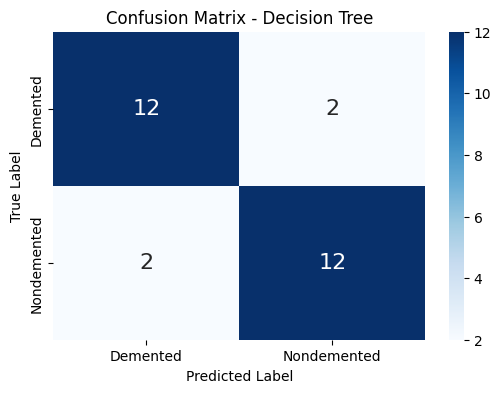

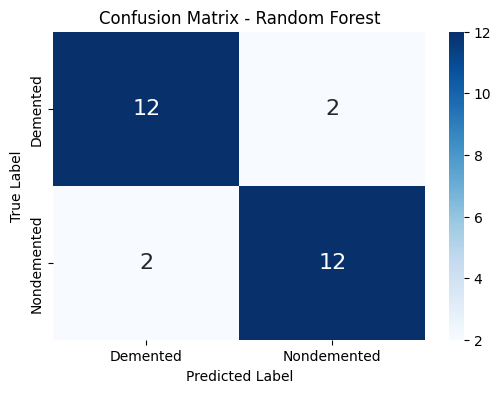

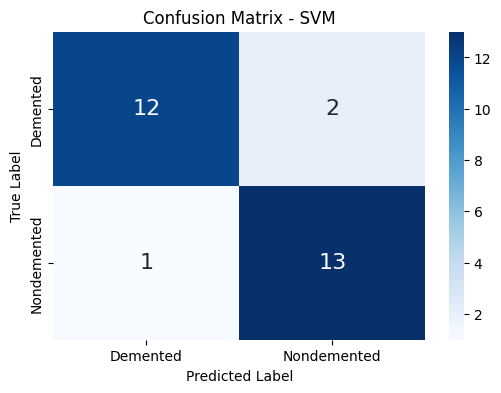

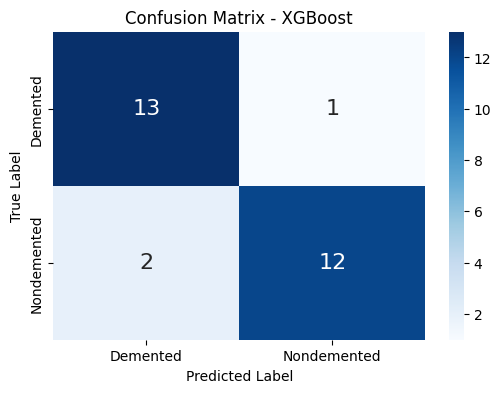

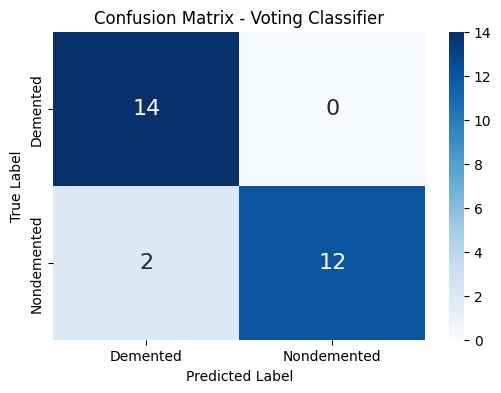

In [534]:
models = [dt_model, rf_model, svm_model, xgb_model, voting_model]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'Voting Classifier']

for model, name in zip(models, model_names):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)

    conf_matrix = confusion_matrix(Y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, xticklabels=['Demented', 'Nondemented'], yticklabels=['Demented', 'Nondemented'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\n")

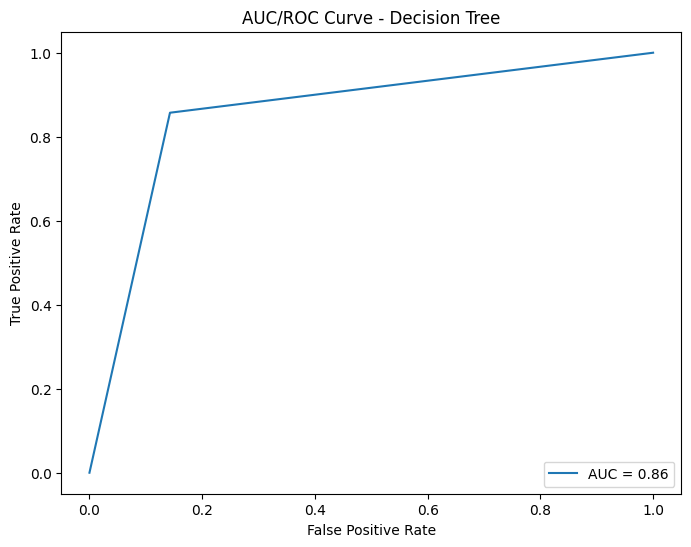

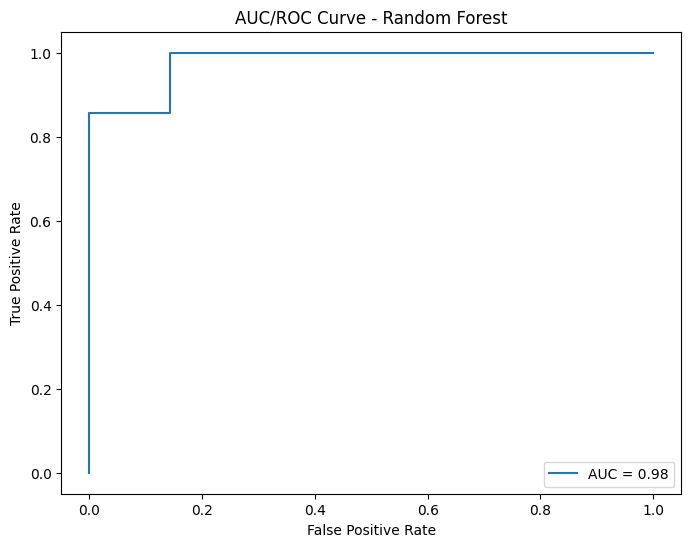

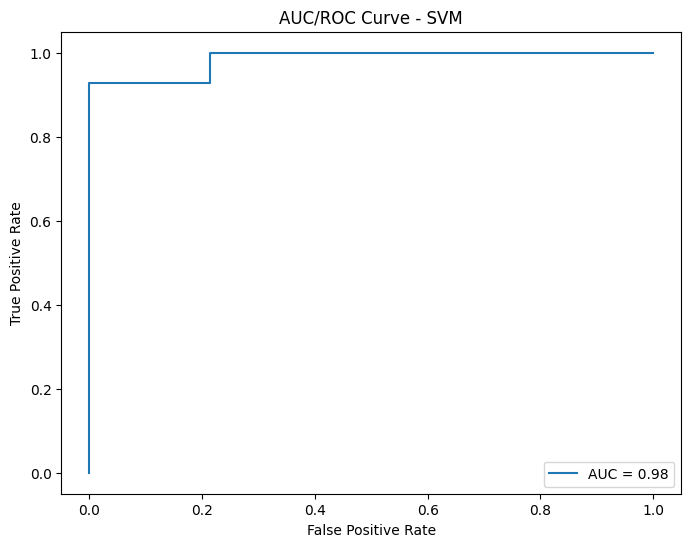

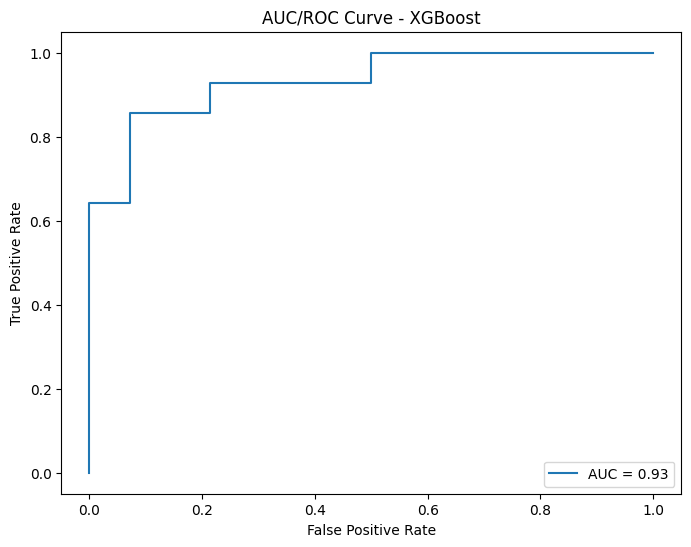

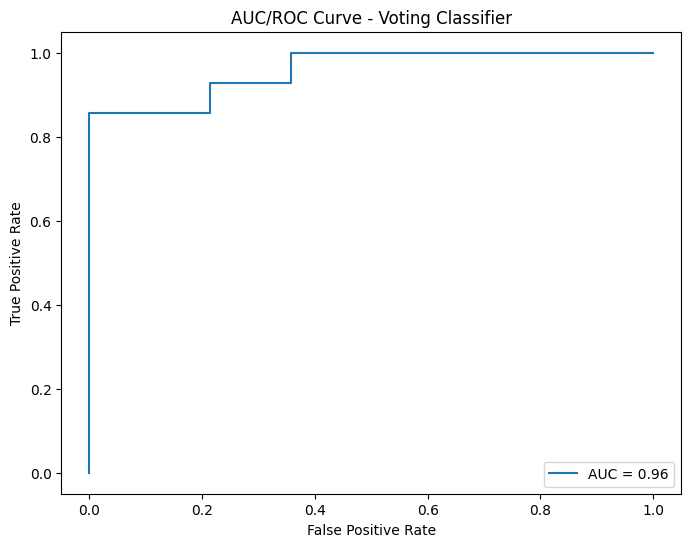

In [535]:
for model, name in zip(models, model_names):
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(Y_test, probabilities[:, 1])
        auc_value = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
        plt.title(f'AUC/ROC Curve - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

### Logistic Regression

First model we're going to try is logistic Regression. We are going to use grid search to try and find optimal combination of the hyperparameters (regularization penalty, strength and optimization algorithm).

In [536]:
model = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, predictions)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [537]:
print("Best Hyperparameters:", best_params)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Test Set: 0.8571428571428571


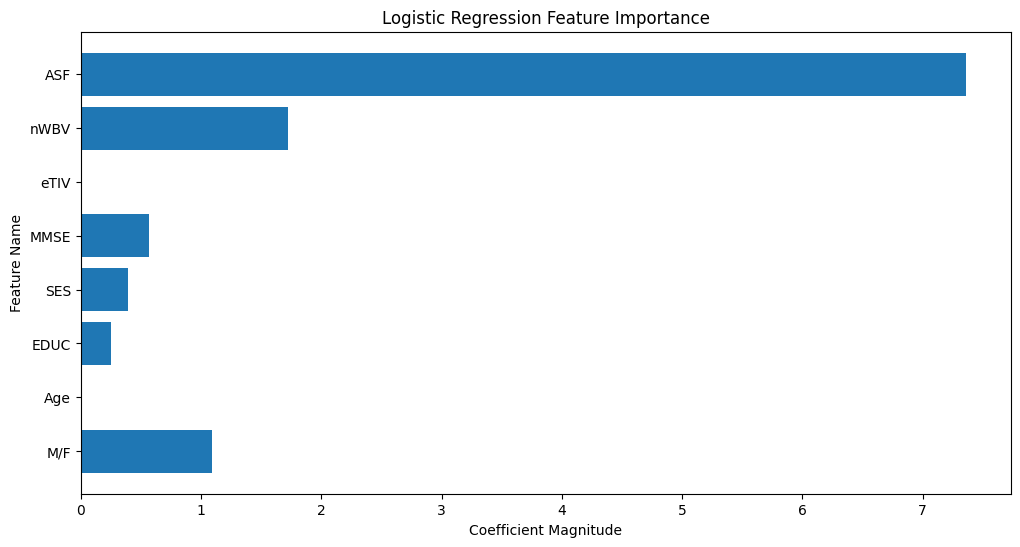

In [538]:
best_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'])
best_model.fit(X_train, Y_train)

coefficients = best_model.coef_[0]
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(feature_names, np.abs(coefficients))
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Name')
plt.show()

### K-Nearest Neighbors (KNN) Classification

Next model we're going to try is K-Nearest Neighbors. We'll try to find optimal hyperparameters among number of neighbors, weight function, algorithm used to compute the nearest neighbors and power parameter for the Minkowski metric.

In [539]:
model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, predictions)

In [540]:
print("Best Hyperparameters:", best_params)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Accuracy on Test Set: 0.75


### Stochastic Gradient Descent (SGDClassifier)

Last algorithm we're going to try is Stohastic Gradient Descent. We'll ude gridsearch to search best combination of hyperparameters for loss function, regularization penalty, strength, maximum number of iterations and tolerance.

In [541]:
model = SGDClassifier()

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [500, 1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, predictions)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

In [542]:
print("Best Hyperparameters:", best_params)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'alpha': 0.1, 'loss': 'hinge', 'max_iter': 3000, 'penalty': 'l1', 'tol': 1e-05}
Accuracy on Test Set: 0.5


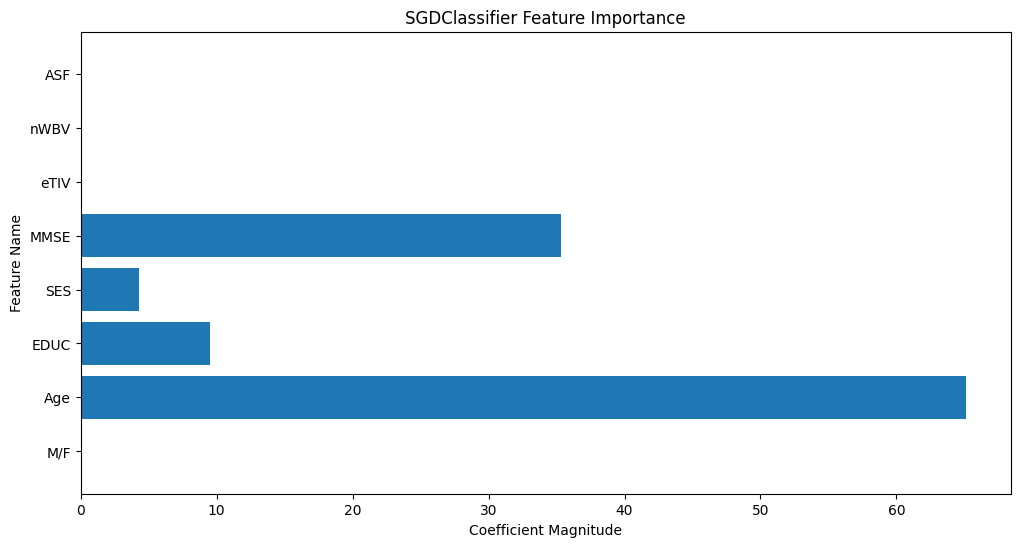

In [543]:
best_model = SGDClassifier(alpha=best_params['alpha'], loss=best_params['loss'], max_iter=best_params['max_iter'], penalty=best_params['penalty'], tol=best_params['tol'])
best_model.fit(X_train, Y_train)

coefficients = best_model.coef_[0]
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(feature_names, np.abs(coefficients))
plt.title('SGDClassifier Feature Importance')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Name')
plt.show()

### Expanding longitudinal dataset by adding cross-sectional dataset

Next, we'll try improving the results by using additional data. We're going to  try using additional data, oasis_cross-sectional dataset.

In [544]:
data_cross = pd.read_csv('/content/drive/My Drive/Colab Notebooks/oasis_cross-sectional.csv')
data_cross.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


We'll edit this dataset to  match the one we previously used: replacing missing values, removing columns (hand, id, Delay, CDR). The educ column of the previous dataset has to be modified because in longitudinal  dataset it contains years of education, while i cross dataset it is a level of education with values from 1 to 5. Also cross dataset does't have the gropu column so we well have to create it using CDR column.

In [545]:
data_cross.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

We have to drop all rows that do not have a value in CDR column as that is what we'll use for our predictions.

In [546]:
data_cross.dropna(subset=['CDR'],inplace=True)
data_cross.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ       0
SES       19
MMSE       0
CDR        0
eTIV       0
nWBV       0
ASF        0
Delay    235
dtype: int64

We're going to fill 19 missing rows with median value, also we're going to remove ID, Hand and Delay columns.

In [547]:
data_cross.loc[data_cross.SES.isna(),'SES'] = data_cross.loc[:,'SES'].median()
data_cross = data_cross.drop(['Hand'],axis=1).drop(['Delay'],axis=1).drop(['ID'], axis=1)
data_cross = data_cross.rename(columns={'Educ':'EDUC'})
data_cross.isna().sum()

M/F     0
Age     0
EDUC    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64

We are going to turn categorical data (M/F) into numerical. F = 0 and M = 1.

In [548]:
label_encoder2 = preprocessing.LabelEncoder()
data_cross['M/F']= label_encoder2.fit_transform(data_cross['M/F'])

"The three groups are based on Clinical Dementia Rating (CDR): cognitive normal (CDR=0), mild cognitive impairment (CDR=0.5), and Alzheimer's disease (CDR≥1.0)"
In ths article, and for the sake of percausion, we'll use any CDR greater than 0 as enouf reason to put someoone in the demented group. We will rename CDR column to Group and set values to 1 if demented and 0 if nondemented.

In [549]:
data_cross.loc[data_cross['CDR'] > 0, 'CDR'] = 1
data_cross['CDR'] = data_cross['CDR'].astype(int)
data_cross.rename(columns={'CDR': 'Group'}, inplace=True)

Next we need to edit EDUC column od longitudinal data, now it represents years person spent in education and we need to divide those years in 5 cathegories. we will do that in the following way:
*   <= 10 to 1
*   11-13 to 2
*   14-16 to 3
*   17-19 to 4
*   20+ to 5






In [550]:
def map_educ(value):
    if value <= 10:
        return 1
    elif 11 <= value <= 13:
        return 2
    elif 14 <= value <= 16:
        return 3
    elif 17 <= value <= 19:
        return 4
    else:
        return 5

In [551]:
data_long['EDUC'] = data_long['EDUC'].apply(map_educ)

Now both our datasets (cross-sectional and longitudinal) are prepared to be merged.

In [552]:
data_long.head()

,Group,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,1,87,3,2.0,27.0,1987,0.696,0.883
2,1,1,75,2,2.0,23.0,1678,0.736,1.046
5,0,0,88,4,3.0,28.0,1215,0.710,1.444
7,0,1,80,2,4.0,28.0,1689,0.712,1.039
10,1,1,71,3,2.0,28.0,1357,0.748,1.293


In [553]:
data_cross.head()

,M/F,Age,EDUC,SES,MMSE,Group,eTIV,nWBV,ASF
0,0,74,2.0,3.0,29.0,0,1344,0.743,1.306
1,0,55,4.0,1.0,29.0,0,1147,0.810,1.531
2,0,73,4.0,3.0,27.0,1,1454,0.708,1.207
8,1,74,5.0,2.0,30.0,0,1636,0.689,1.073
9,0,52,3.0,2.0,30.0,0,1321,0.827,1.329


In [554]:
data_all = pd.concat([data_cross, data_long])
data_all.describe()

,M/F,Age,EDUC,SES,MMSE,Group,eTIV,nWBV,ASF
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,0.369272,73.420485,3.040431,2.479784,27.177898,0.442049,1466.334232,0.744280,1.211908
std,0.483259,10.733429,1.197287,1.086276,3.471217,0.497301,167.208177,0.044599,0.133590
min,0.000000,33.000000,1.000000,1.000000,14.000000,0.000000,1123.000000,0.644000,0.881000
25%,0.000000,68.000000,2.000000,2.000000,26.000000,0.000000,1348.000000,0.710000,1.130500
50%,0.000000,74.000000,3.000000,2.000000,29.000000,0.000000,1450.000000,0.742000,1.210000
75%,1.000000,80.500000,4.000000,3.000000,30.000000,1.000000,1552.500000,0.774500,1.302000
max,1.000000,96.000000,5.000000,5.000000,30.000000,1.000000,1992.000000,0.847000,1.563000


Again, we are going to divide our data set into training set (80%) and test set (20%).


In [555]:
X = data_all.drop(['Group'],axis=1)
Y = data_all['Group']

In [556]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

296
296
75
75


First of all, we are going to try using same models as in article on this, larger dataset.

In [557]:
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
xgb_model = XGBClassifier(random_state=42)
voting_model = VotingClassifier(estimators=[
    ('dt', dt_model),
    ('rf', rf_model),
    ('svm', svm_model),
    ('xgb', xgb_model)
], voting='soft')

models = [dt_model, rf_model, svm_model, xgb_model, voting_model]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'Voting Classifier']
results_dict_all = {'Model': [], 'Mean Accuracy': [], 'Test Accuracy': [], 'Test Precision': [], 'Test Recall': [], 'Test F1 Score': []}

for model, name in zip(models, model_names):
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring='accuracy')
    print(f"{name}")
    print(f"Mean Accuracy: {scores.mean()}")
    results_dict_all['Mean Accuracy'].append(scores.mean())
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions, average='weighted', zero_division=1)
    recall = recall_score(Y_test, predictions, average='weighted', zero_division=1)
    f1 = f1_score(Y_test, predictions, average='weighted', zero_division=1)

    results_dict_all['Model'].append(name)
    results_dict_all['Test Accuracy'].append(accuracy)
    results_dict_all['Test Precision'].append(precision)
    results_dict_all['Test Recall'].append(recall)
    results_dict_all['Test F1 Score'].append(f1)

    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test F1 Score: {f1}\n")

Decision Tree
Mean Accuracy: 0.8245977011494254
Test Accuracy: 0.8533333333333334
Test Precision: 0.853110465116279
Test Recall: 0.8533333333333334
Test F1 Score: 0.8530678733031675

Random Forest
Mean Accuracy: 0.8347126436781609
Test Accuracy: 0.8933333333333333
Test Precision: 0.8966116941529234
Test Recall: 0.8933333333333333
Test F1 Score: 0.8923167155425218

SVM
Mean Accuracy: 0.8317241379310344
Test Accuracy: 0.88
Test Precision: 0.8916483516483518
Test Recall: 0.88
Test F1 Score: 0.8774967405475881

XGBoost
Mean Accuracy: 0.8449425287356321
Test Accuracy: 0.92
Test Precision: 0.9207038123167155
Test Recall: 0.92
Test F1 Score: 0.9196802325581395

Voting Classifier
Mean Accuracy: 0.8480459770114942
Test Accuracy: 0.88
Test Precision: 0.8813333333333333
Test Recall: 0.88
Test F1 Score: 0.8792118226600985



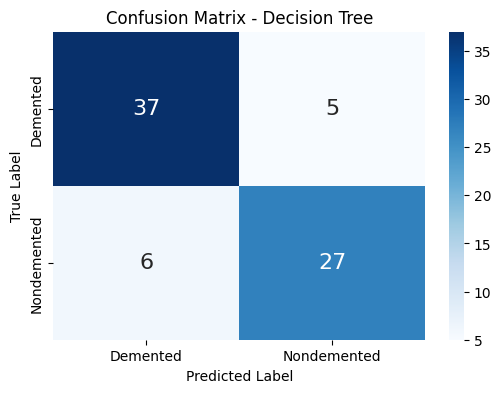

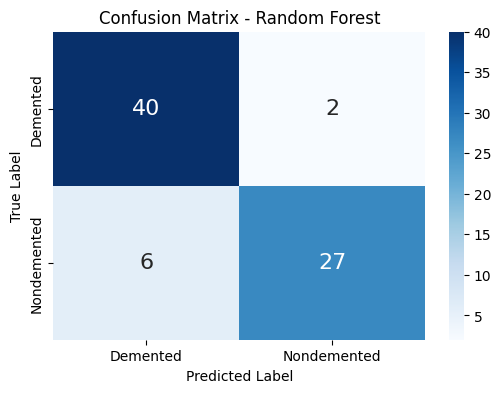

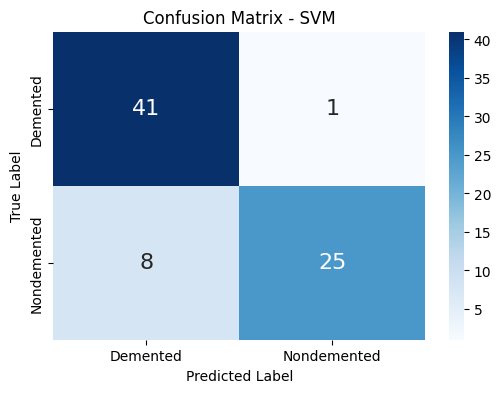

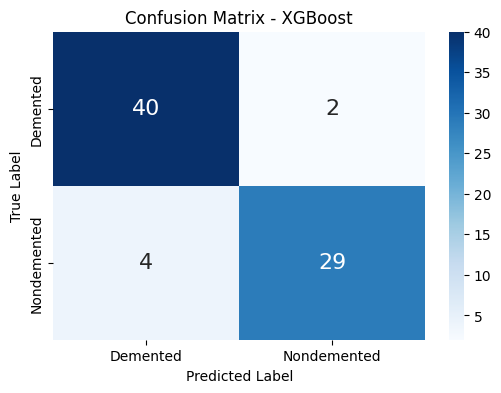

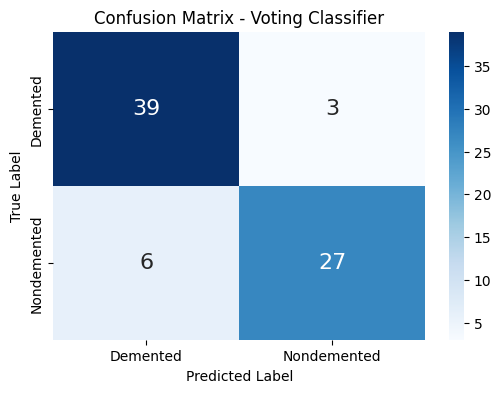

In [558]:
models = [dt_model, rf_model, svm_model, xgb_model, voting_model]
model_names = ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost', 'Voting Classifier']

for model, name in zip(models, model_names):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)

    conf_matrix = confusion_matrix(Y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16}, xticklabels=['Demented', 'Nondemented'], yticklabels=['Demented', 'Nondemented'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\n")

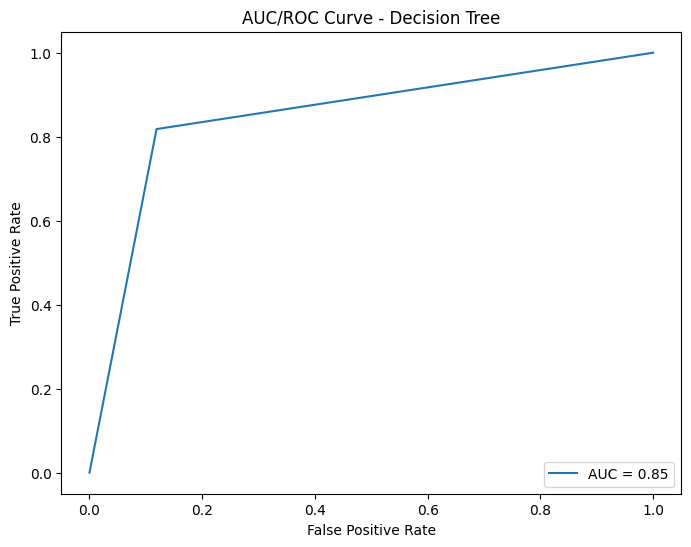

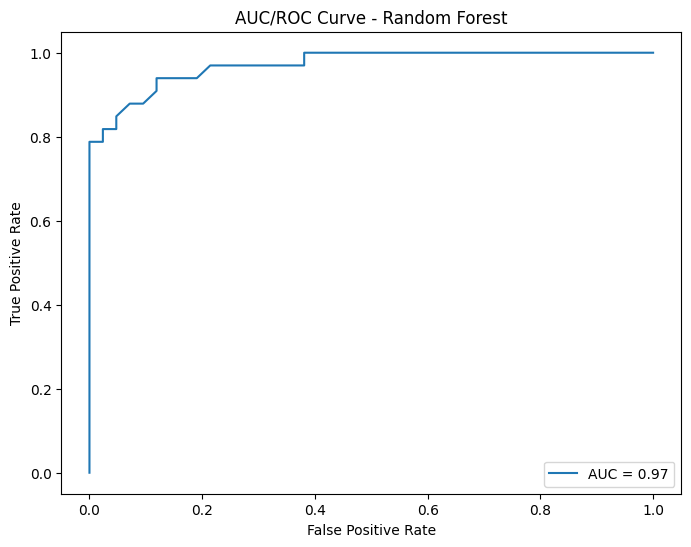

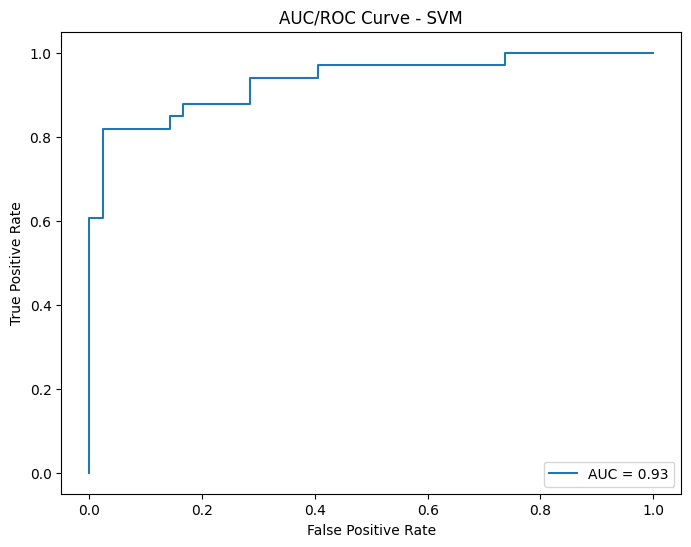

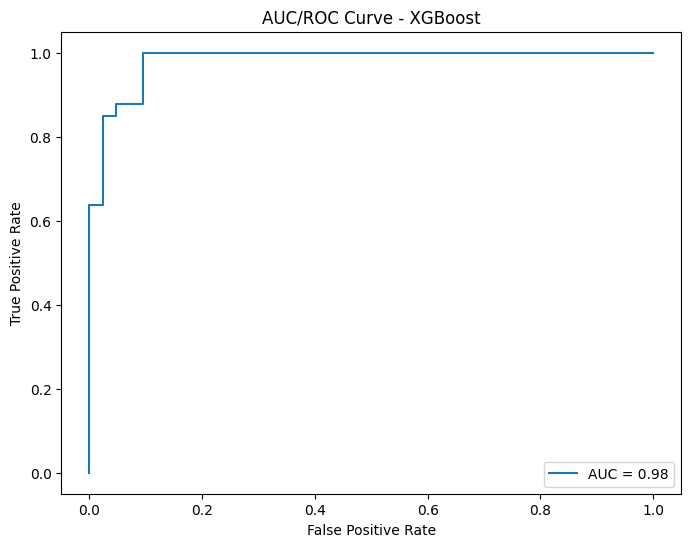

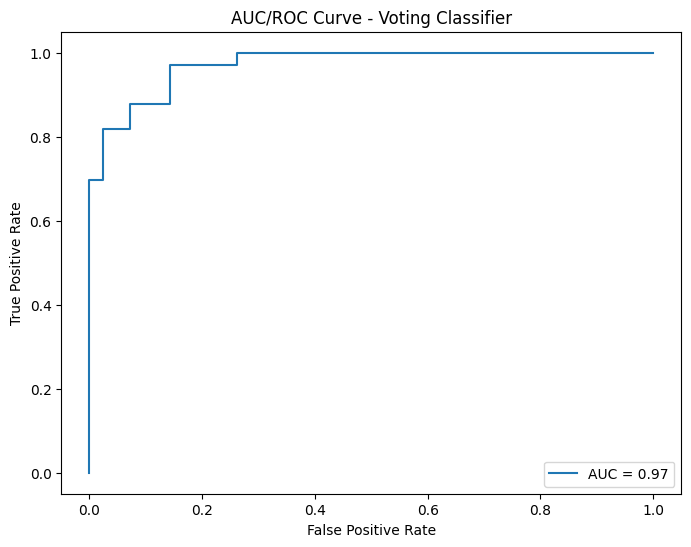

In [559]:
for model, name in zip(models, model_names):
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(Y_test, probabilities[:, 1])
        auc_value = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
        plt.title(f'AUC/ROC Curve - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

### Logistic regression

Again, we're going to try is logistic Regression. We are going to use grid search to try and find optimal combination of the hyperparameters (regularization penalty, strength and optimization algorithm).

In [560]:
model = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [561]:
print("Best Hyperparameters:", best_params)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on Test Set: 0.8266666666666667


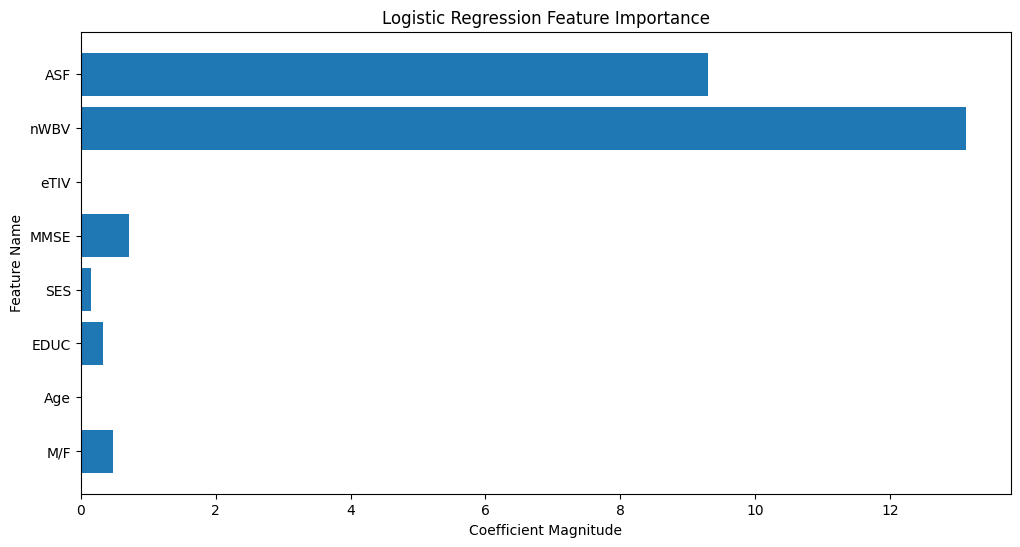

In [562]:
best_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'])
best_model.fit(X_train, Y_train)

coefficients = best_model.coef_[0]
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(feature_names, np.abs(coefficients))
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Name')
plt.show()

### K-Nearest Neighbors (KNN) Classification

Next, we're going to try is K-Nearest Neighbors. We'll try to find optimal hyperparameters among number of neighbors, weight function, algorithm used to compute the nearest neighbors and power parameter for the Minkowski metric.

In [563]:
model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, predictions)

In [564]:
print("Best Hyperparameters:", best_params)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Accuracy on Test Set: 0.8


### Stochastic Gradient Descent (SGDClassifier)

As before, last algorithm we're going to try is Stohastic Gradient Descent. We'll ude gridsearch to search best combination of hyperparameters for loss function, regularization penalty, strength, maximum number of iterations and tolerance.

In [565]:
model = SGDClassifier()

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [500, 1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(Y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

In [566]:
print("Best Hyperparameters:", best_params)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'alpha': 0.01, 'loss': 'modified_huber', 'max_iter': 2000, 'penalty': 'l1', 'tol': 1e-05}
Accuracy on Test Set: 0.6133333333333333


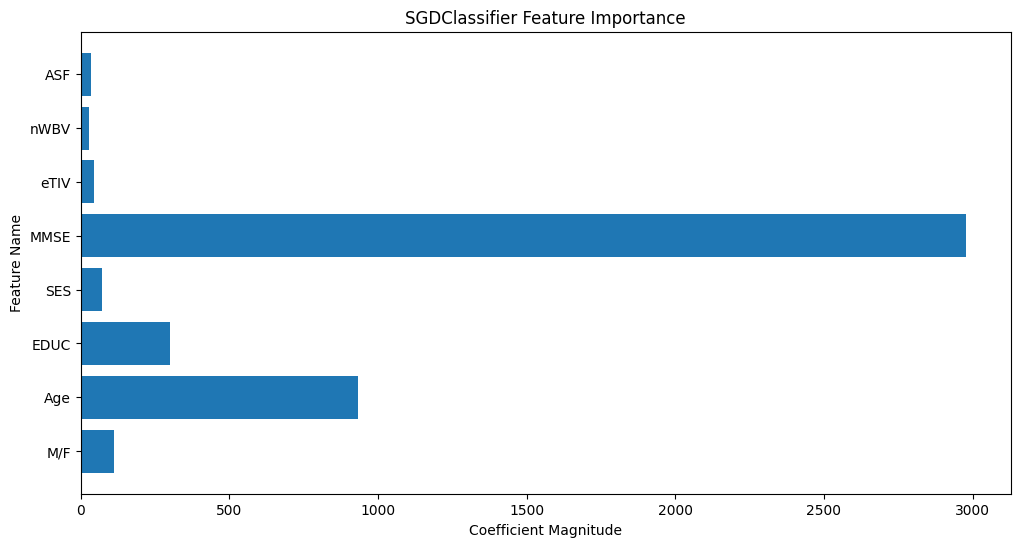

In [567]:
best_model = SGDClassifier(alpha=best_params['alpha'], loss=best_params['loss'], max_iter=best_params['max_iter'], penalty=best_params['penalty'], tol=best_params['tol'])
best_model.fit(X_train, Y_train)

coefficients = best_model.coef_[0]
feature_names = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(feature_names, np.abs(coefficients))
plt.title('SGDClassifier Feature Importance')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Name')
plt.show()

## Usporedba

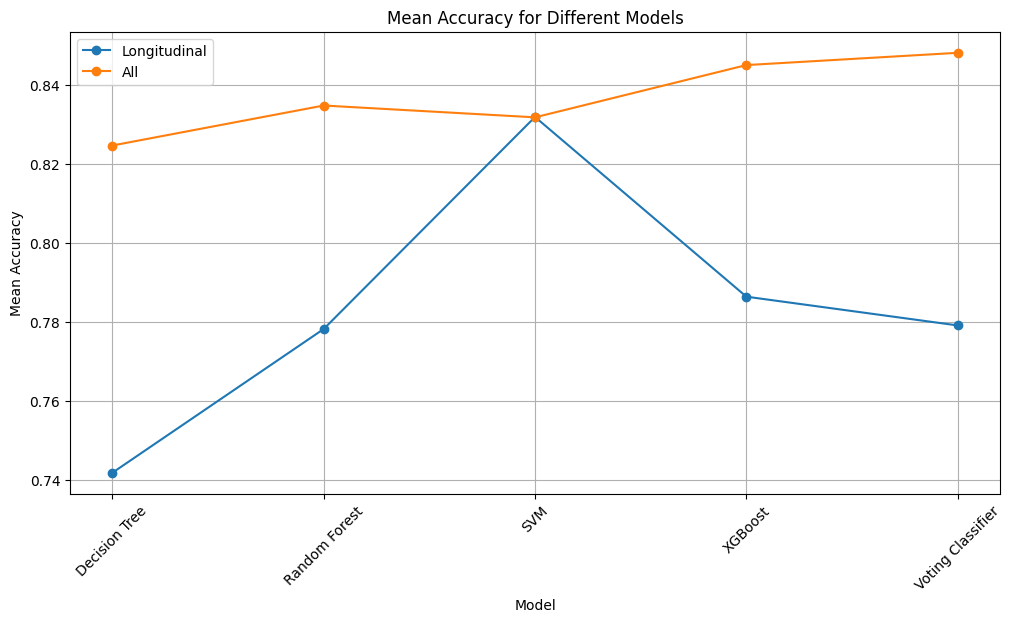

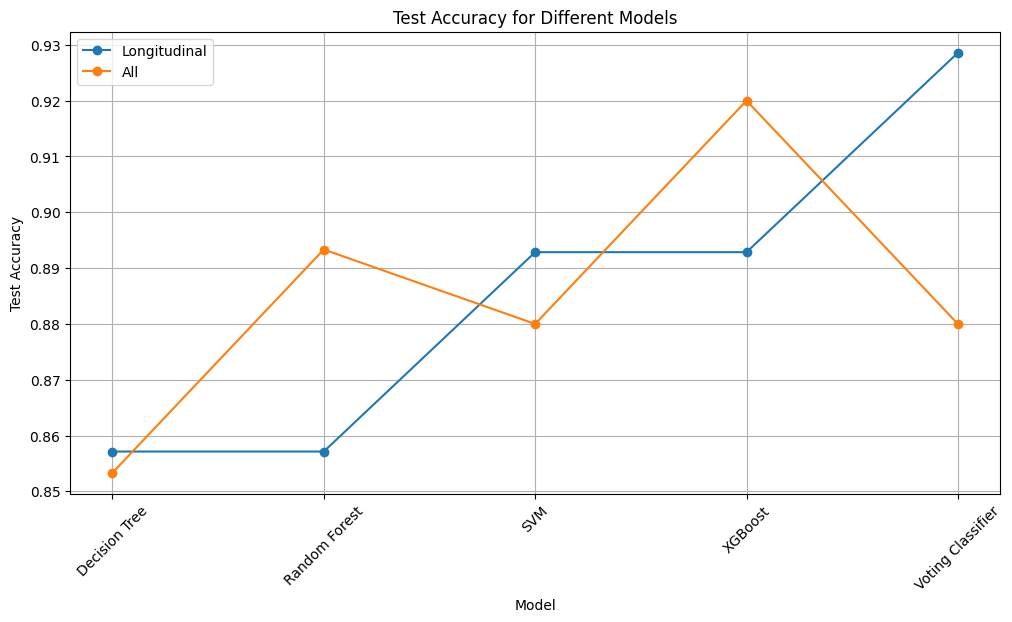

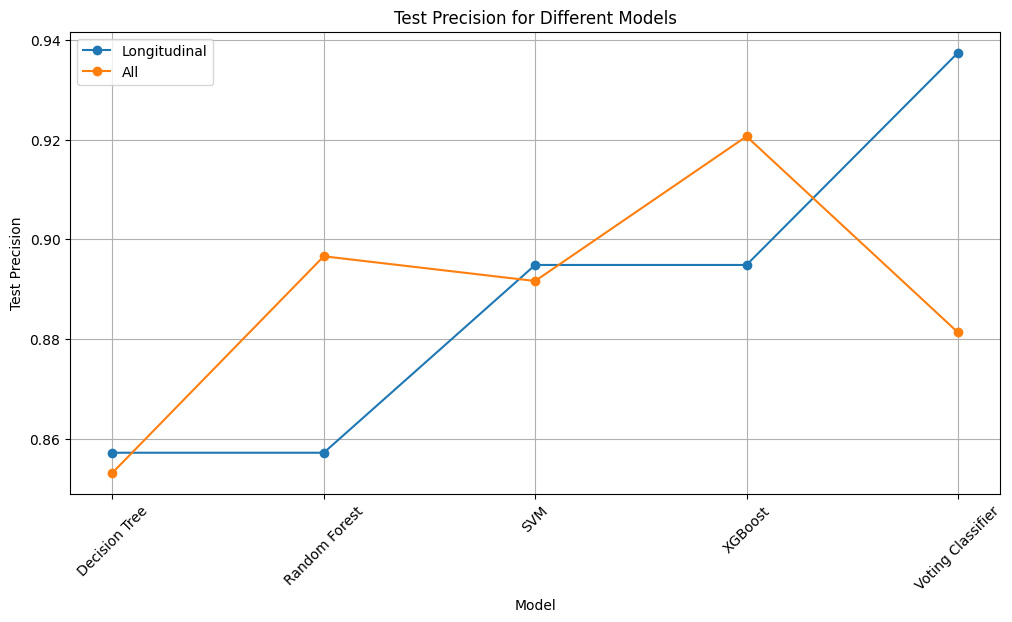

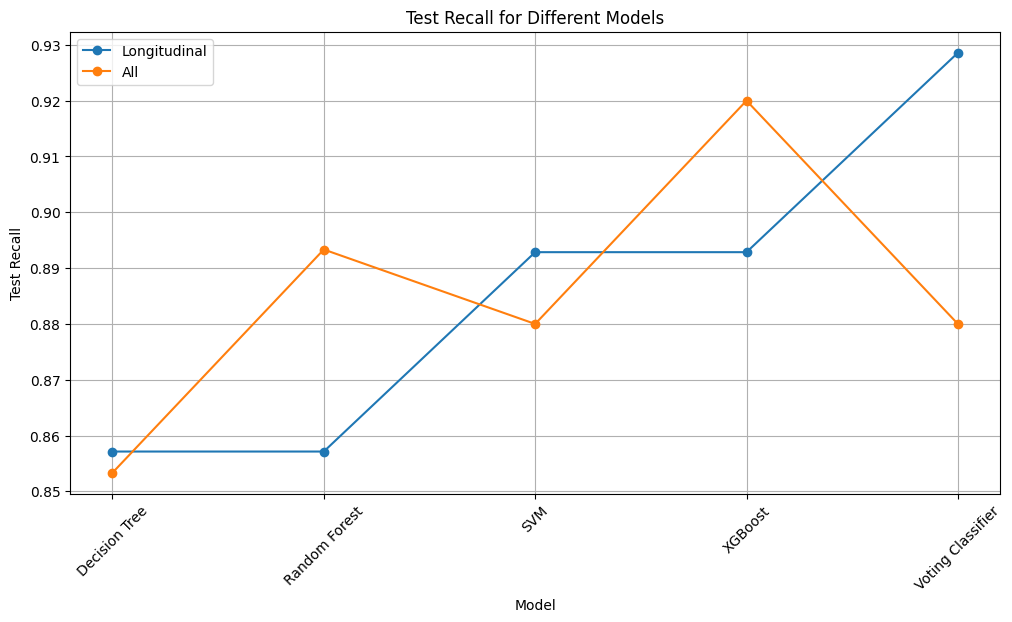

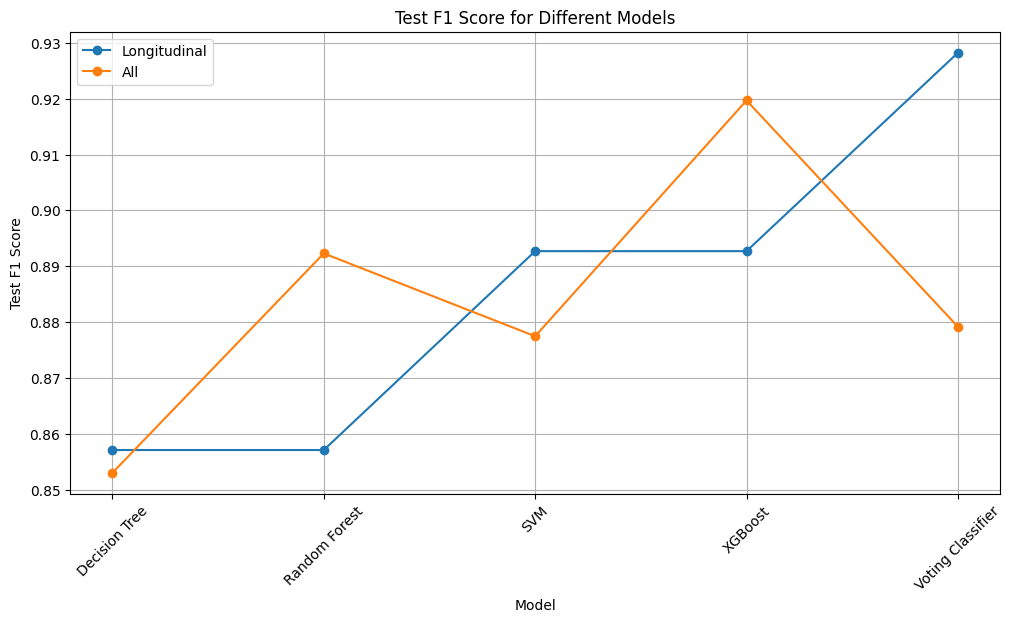

In [568]:
df_longitudinal = pd.DataFrame(results_dict_long)
df_all = pd.DataFrame(results_dict_all)

metrics = ['Mean Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    plt.plot(df_longitudinal['Model'], df_longitudinal[metric], marker='o', label='Longitudinal')
    plt.plot(df_all['Model'], df_all[metric], marker='o', label='All')

    plt.title(f'{metric} for Different Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

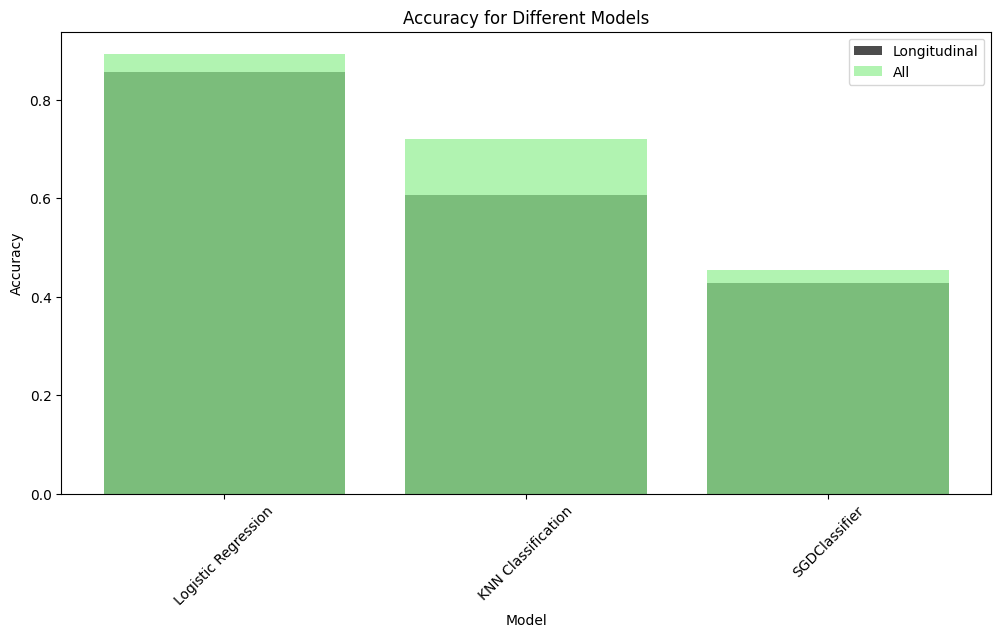

In [569]:
results_dict_longitudinal = {
    'Model': ['Logistic Regression', 'KNN Classification', 'SGDClassifier'],
    'Accuracy': [0.8571428571428571, 0.6071428571428571, 0.42857142857142855]
}

results_dict_all = {
    'Model': ['Logistic Regression', 'KNN Classification', 'SGDClassifier'],
    'Accuracy': [0.8933333333333333, 0.72, 0.4533333333333333]
}

df_longitudinal = pd.DataFrame(results_dict_longitudinal)
df_all = pd.DataFrame(results_dict_all)

metrics = ['Accuracy']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    plt.bar(df_longitudinal['Model'], df_longitudinal[metric], color='black', label='Longitudinal', alpha=0.7)
    plt.bar(df_all['Model'], df_all[metric], color='lightgreen', label='All', alpha=0.7)

    plt.title(f'{metric} for Different Models')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()